In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [11]:
CSV_PATH = "/content/drive/MyDrive/theLeapNov2025Returns.csv"

In [12]:
import re
import pandas             as pd
import numpy              as np
import matplotlib.dates   as mdates
import matplotlib.pyplot  as plt
import matplotlib.patches as mpatches

from matplotlib.collections import LineCollection
from sklearn.linear_model   import LinearRegression


def mean(data, weights, length):
    data    = data   [-length:]
    weights = weights[-length:]

    return np.sum(data * weights) / np.sum(weights)


def apply_equity_drift(data):
    modified_data = np.append(data.values[1:], data.values[-1])

    try:
        return mean(modified_data, np.ones(len(modified_data)), data.size)
    except ValueError as e:
        return np.nan


def apply_pnl_drift(data):
    try:
        return mean(data.values, np.arange(1, data.size + 1, dtype=float), data.size)
    except ValueError as e:
        return np.nan


def apply_pnl_vola(data):
    try:
        return mean(np.arange(1, data.size + 1, dtype=float), np.abs(data.values), data.size)
    except ValueError as e:
        return np.nan


def apply_pnl_vola_ref(data):
    try:
        return mean(np.arange(1, data.size + 1, dtype=float), np.ones(len(data)), data.size)
    except ValueError as e:
        return np.nan


def apply_equity_trend(data):
    try:
        # X = index positions (0..len-1), reshaped for sklearn
        X = np.arange(len(data)).reshape(-1, 1)
        y = data.values

        model = LinearRegression()

        model.fit(X, y)

        # Predict the last point (endpoint)
        return model.predict([[len(data)-1]])[0]
    except Exception:
        return np.nan


def apply_equity_cycle(data):
    try:
        x = data.values.astype(float)
        N = x.size
        if N < 3:
            return np.nan

        # FFT
        X   = np.fft.fft(x)
        mag = np.abs(X)

        # Frequency bins
        freqs = np.fft.fftfreq(N, d=1.0)

        # Half-spectrum indices
        half_idxs = np.arange(0, N//2 + 1)

        # Exclude DC (bin 0) if N >= 3
        start_idx = 1 if N >= 3 else 0
        if start_idx >= len(half_idxs):
            return np.nan

        search_idxs = half_idxs[start_idx:]

        # Find dominant bin in half-spectrum (excluding DC)
        dom_rel = np.argmax(mag[search_idxs])
        max_idx = search_idxs[dom_rel]

        # Keep max_idx ±1 bins
        keep_mode = 1
        bins_to_keep = [(max_idx + off) % N for off in range(-keep_mode, keep_mode + 1)]

        # Filtered spectrum
        Xf = np.zeros_like(X, dtype=complex)

        def keep_bin(bin_idx):
            mirror = (-bin_idx) % N
            Xf[bin_idx] = X[bin_idx]
            if mirror != bin_idx:
                Xf[mirror] = X[mirror]

        for b in bins_to_keep:
            keep_bin(b)

        # Inverse FFT
        x_rec = np.fft.ifft(Xf).real

        # Endpoint
        return float(x_rec[-1])

    except Exception:
        return np.nan

In [13]:
LENGTH_PNL    = 64
LENGTH_EQUITY = 16

#  get data ready
df         = pd.read_csv(CSV_PATH)
df['Time'] = pd.to_datetime(df['Time'])
df         = df.sort_values('Time').reset_index(drop=True) if 'Time' in df.columns else df.reset_index(drop=True)

df['balance_after' ] = pd.to_numeric(df['Balance After'       ], errors='coerce')
df['balance_before'] = pd.to_numeric(df['Balance Before'      ], errors='coerce')
df['pnl'           ] = pd.to_numeric(df['Realized P&L (value)'], errors='coerce').fillna(0.0)

#  fee rows detection
FEE_KEYWORDS = ['commission', 'fee']
pattern      = re.compile("|".join(FEE_KEYWORDS), flags=re.IGNORECASE)
df['is_fee'] = df['Action'].astype(str).apply(lambda s: bool(pattern.search(s)))

#  process data
df['fee_pnl' ] = np.where(df['is_fee'], df['pnl'], 0.0)
df['cum_fees'] = df['fee_pnl'].cumsum()

fees = abs(df.loc[df['is_fee'],'pnl'].sum())


df['equity'        ] = df['balance_after']
df['equity_no_fees'] = df['equity'] - df['cum_fees']

df['equity_drift'    ] = df['equity'].rolling(LENGTH_EQUITY).apply(apply_equity_drift, raw=False)
df['equity_dedrifted'] = df['equity'] - df['equity_drift']

df['equity_trend'    ] = df['equity_dedrifted'].rolling(LENGTH_EQUITY).apply(apply_equity_trend, raw=False)
df['equity_detrended'] = df['equity_dedrifted'] - df['equity_trend']

df['equity_cycle'] = df['equity_detrended'].rolling(LENGTH_EQUITY).apply(apply_equity_cycle, raw=False)

df['equity_drift_centered'] = df['equity_drift'] - df['equity'].shift(LENGTH_EQUITY)


pnl_rows = df.loc[~df['is_fee']].copy()

pnl_rows['pnl_drift'        ] = pnl_rows['pnl'].rolling(LENGTH_PNL).apply(apply_pnl_drift   , raw=False)
pnl_rows['pnl_vola'         ] = pnl_rows['pnl'].rolling(LENGTH_PNL).apply(apply_pnl_vola    , raw=False)
pnl_rows['pnl_vola_ref'     ] = pnl_rows['pnl'].rolling(LENGTH_PNL).apply(apply_pnl_vola_ref, raw=False)
pnl_rows['pnl_vola_centered'] = pnl_rows['pnl_vola'] - pnl_rows['pnl_vola_ref']

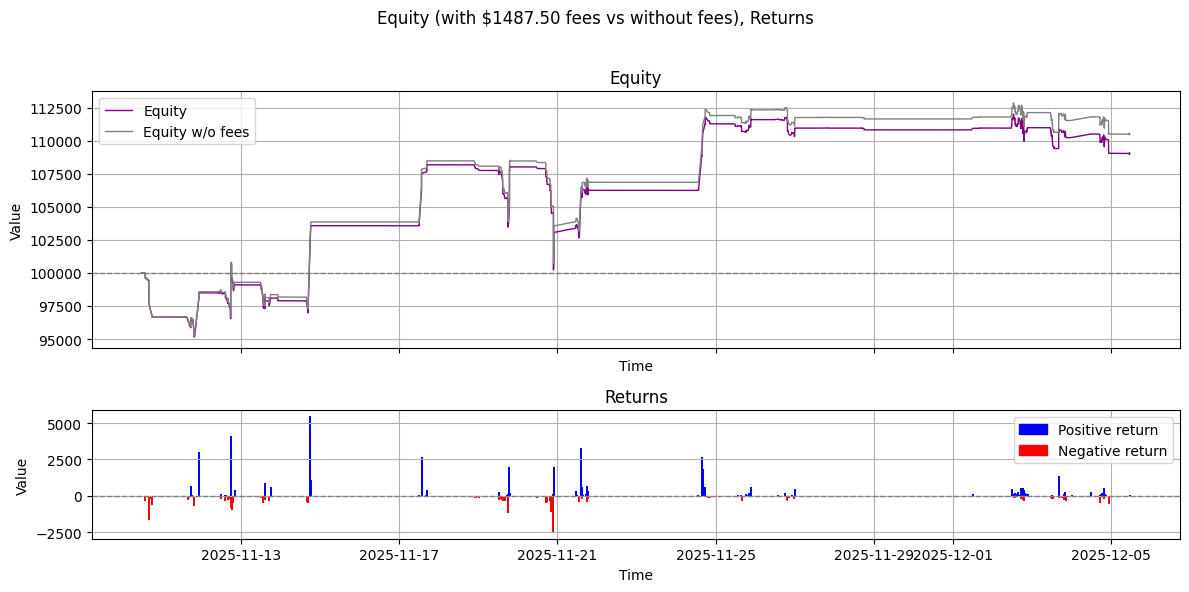

In [17]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(12,6), gridspec_kw={'height_ratios':[2,1]})

#  upper plot
ax1.plot(df['Time'], df['equity'        ], label='Equity'         , linewidth=1, color='purple')
ax1.plot(df['Time'], df['equity_no_fees'], label='Equity w/o fees', linewidth=1, color='gray'  )

ax1.axhline(y=100000, color='gray', linestyle='--', linewidth=1)

ax1.set_ylabel('Value')
ax1.legend()
ax1.grid(True)
ax1.set_title('Equity')
ax1.set_xlabel('Time')

#  lower plot
color_bar = np.where(pnl_rows['pnl'] >= 0, 'blue', 'red')
neg_patch = mpatches.Patch(color='red' , label='Negative return')
pos_patch = mpatches.Patch(color='blue', label='Positive return')

ax2.bar(pnl_rows['Time'], pnl_rows['pnl'], width=0.05, label='Returns w/o fees', color = color_bar)

ax2.axhline(y=0, color='gray', linestyle='--', linewidth=1)

ax2.set_xlabel('Time')
ax2.set_ylabel('Value')
ax2.legend(handles=[pos_patch, neg_patch])
ax2.grid(True)
ax2.set_title('Returns')

plt.suptitle(f'Equity (with ${fees:.2f} fees vs without fees), Returns')
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

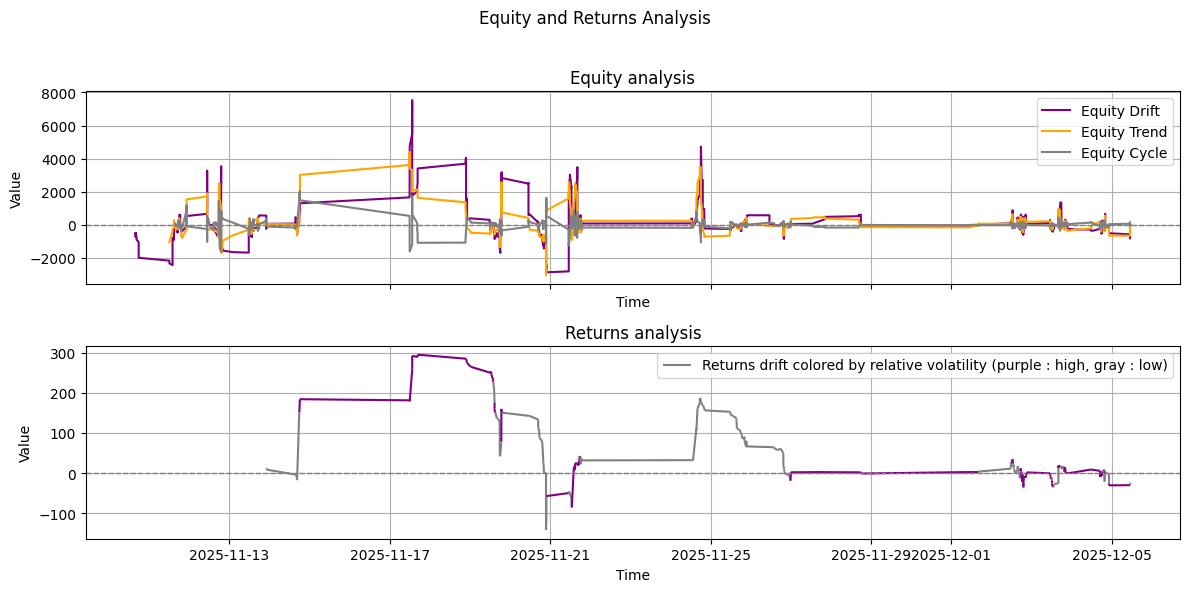

In [15]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(12,6))

#  upper plot
ax1.plot(df['Time'], df['equity_drift_centered'], label='Equity Drift', color='purple')
ax1.plot(df['Time'], df['equity_trend'         ], label='Equity Trend', color='orange')
ax1.plot(df['Time'], df['equity_cycle'         ], label='Equity Cycle', color='gray'  )

ax1.axhline(y=0, color='gray', linestyle='--', linewidth=1)

ax1.set_ylabel('Value')
ax1.legend()
ax1.grid(True)
ax1.set_title('Equity analysis')
ax1.set_xlabel('Time')

#  lower plot
y    = pnl_rows['pnl_drift'].values
vola = pnl_rows['pnl_vola_centered'].values

xnum     = mdates.date2num(pnl_rows['Time']) # Convert datetime objects to numerical format for LineCollection
pts      = np.column_stack([xnum, y])
segments = np.stack([pts[:-1], pts[1:]], axis=1)  # shape (N-1, 2, 2)

signs     = (vola > 0)
color_seg = np.where(signs[:-1], 'purple', 'gray')

ax2.add_collection(LineCollection(segments, colors=color_seg, linewidths=1.5, linestyles='-'))
ax2.autoscale_view()

ax2.axhline(y=0, color='gray', linestyle='--', linewidth=1)

ax2.set_xlabel('Time')
ax2.set_ylabel('Value')
ax2.legend(['Returns drift colored by relative volatility (purple : high, gray : low)'])
ax2.grid(True)
ax2.set_title('Returns analysis')

plt.suptitle('Equity and Returns Analysis')
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()